# references
#   https://datascience.stackexchange.com/questions/29520/how-to-plot-learning-curve-and-validation-curve-while-using-pipeline

In [82]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing.label import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.svm import SVC 



from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report




In [86]:
def vanilla_fit(pipe):
    pipe.fit(X_train, y_train)
    train_score = pipe.score(X_train, y_train)
    print(train_score)
    test_score = pipe.score(X_test, y_test)
    print(test_score)
    #print(accuracy_score(y_test, pipe.predict(X_test)))
    return train_score, test_score


def generate_validation_curve(pipe, X_train, y_train, model, param_name, search_range,   data='wine'):
    train_scores, test_scores = validation_curve(estimator=pipe, X=X_train, y=y_train, 
                                                 param_name="cfr__"+param_name,
                                                 param_range=search_range, cv=5,
                                                 n_jobs=-1)
    plt.figure(figsize=(5,5))
    plt.plot(search_range, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(search_range, np.mean(test_scores, axis=1), label='Cross-validation score')
    plt.title('Validation curve for{}'.format(model))
    plt.xlabel(param_name)
    plt.ylabel("Classification score")
    plt.legend(loc="best")
    plt.grid()

    plt.savefig(r'..\plot\{}_val_curve_{}_{}.png'.format(data, model, param_name), figsize=(5, 5))
    plt.show()

    
# Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


In [4]:
data = 'wine'
if data == 'wine':
    df = pd.read_csv(r'..\data\winequality-white.csv', sep=';')
    
print(df.shape)
print(df.info())

(4898, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
None


In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


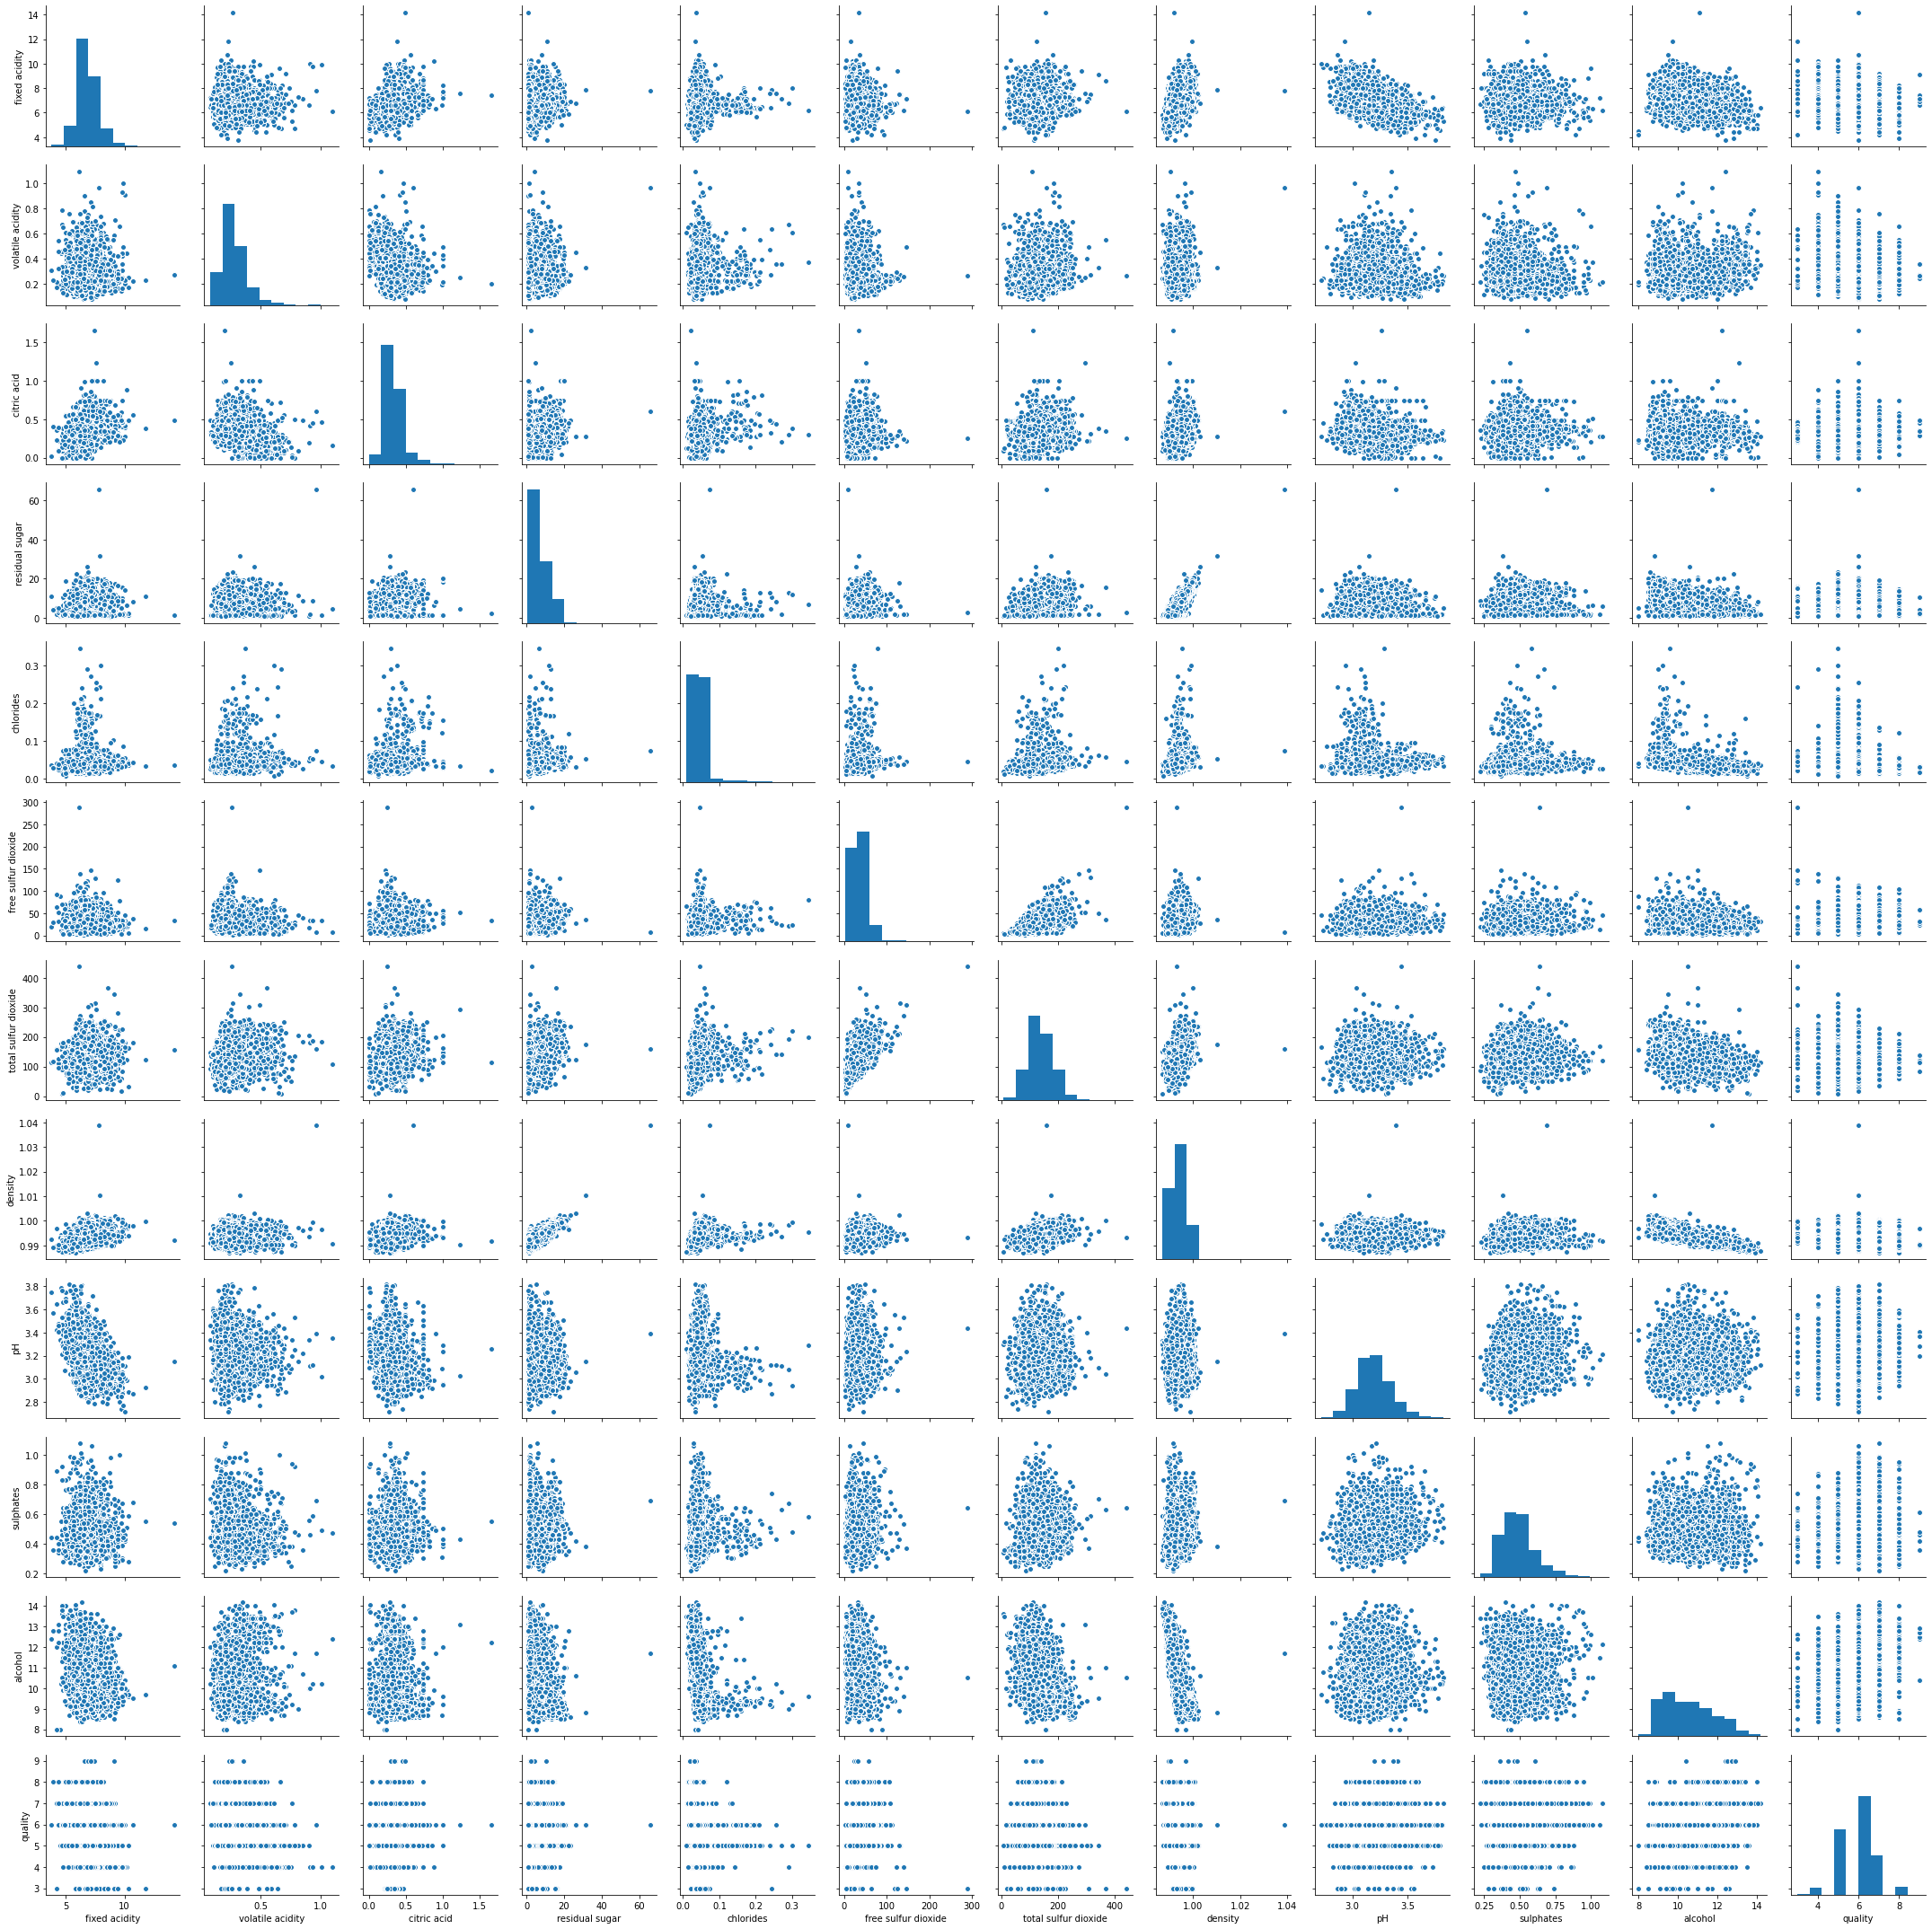

<Figure size 1440x1440 with 0 Axes>

In [11]:
plt.rcParams["figure.figsize"] = (20,20)
# Basic correlogram
sns.pairplot(df)
plt.show()
plt.savefig(r'..\plot\{}_scatterplot.png'.format(data), figsize=(20, 20))


In [5]:
y = df['quality'] >= 7

X = df.drop(columns='quality')

#enc = LabelEncoder()
#y = enc.fit_transform(df.quality)

print(X.shape)
print(y.shape)
print(X.head())
print('====')
#print(y.head())
y

(4898, 11)
(4898,)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  
0      8.8  
1      9.5  
2     10.1  
3      9.9  
4 

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13       True
14      False
15       True
16      False
17       True
18      False
19      False
20       True
21       True
22       True
23      False
24      False
25      False
26      False
27      False
28      False
29       True
        ...  
4868    False
4869    False
4870     True
4871    False
4872    False
4873    False
4874    False
4875    False
4876     True
4877    False
4878    False
4879    False
4880    False
4881    False
4882    False
4883    False
4884    False
4885    False
4886     True
4887     True
4888    False
4889    False
4890    False
4891    False
4892    False
4893    False
4894    False
4895    False
4896     True
4897    False
Name: quality, Length: 4898, dtype: bool


# TRAIN TEST SPLIT

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.rcParams["figure.figsize"] = (10,10)

# DECISION TREE

In [68]:


pipe = Pipeline([('std', StandardScaler()), ('cfr', DecisionTreeClassifier())])

vanilla_fit(pipe)


1.0
0.8238095238095238


(1.0, 0.8238095238095238)

0.23.2


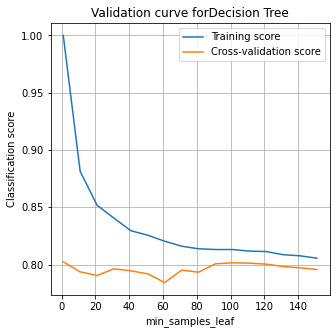

In [87]:
import sklearn
print(sklearn.__version__)
#validation_curve(pipe, X_train, y_train, 
#                                                 param_name=r"cfr__".format("min_samples_leaf"),
#                                                 param_range=np.arange(1, 160, 10), cv=5, n_jobs=-1
#                                                 )
generate_validation_curve(pipe, X_train, y_train, model='Decision Tree', param_name="min_samples_leaf", search_range=np.arange(1, 160, 10), data='wine')



[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
{'criterion': 'gini', 'splitter': 'best', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': None, 'max_leaf_nodes': None, 'random_state': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'class_weight': None, 'presort': 'deprecated', 'ccp_alpha': 0.0}


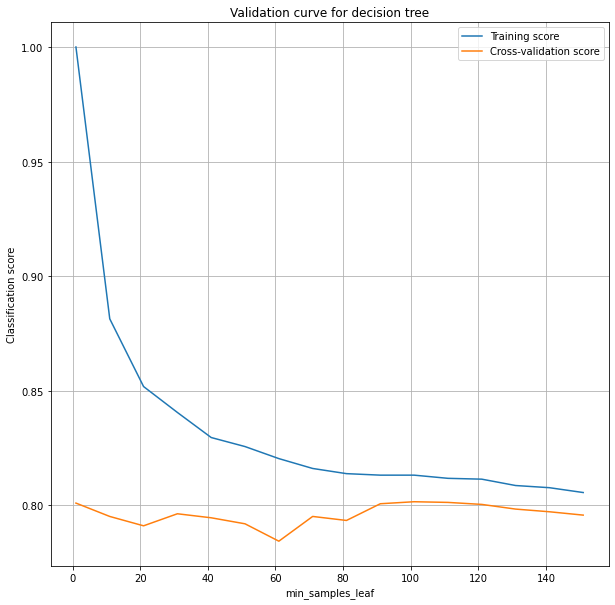

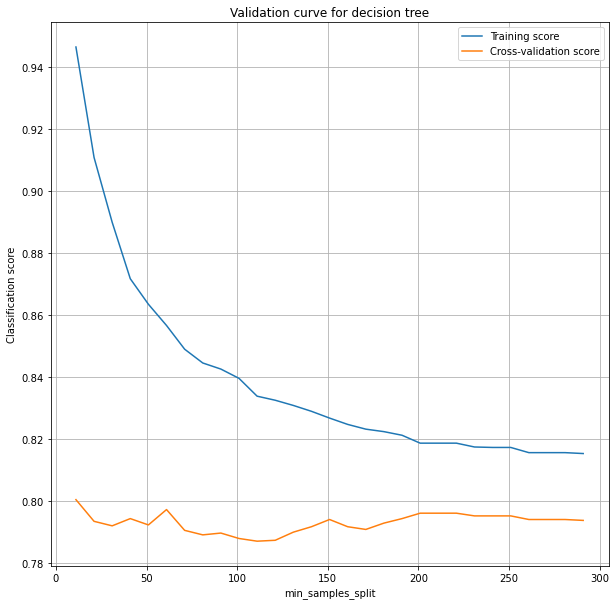

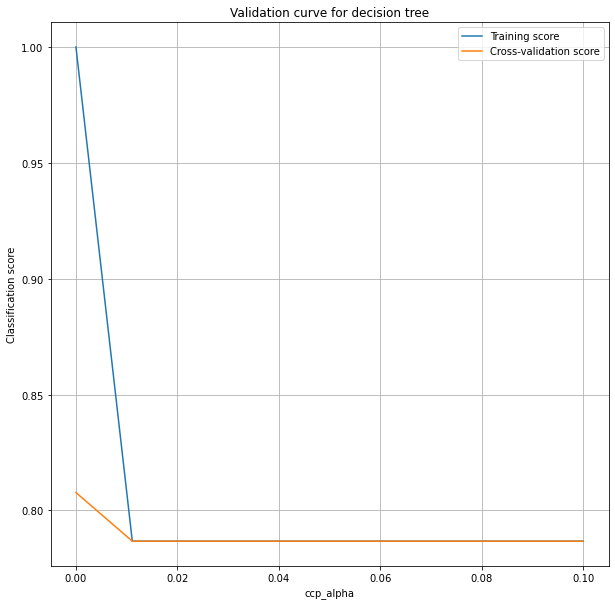

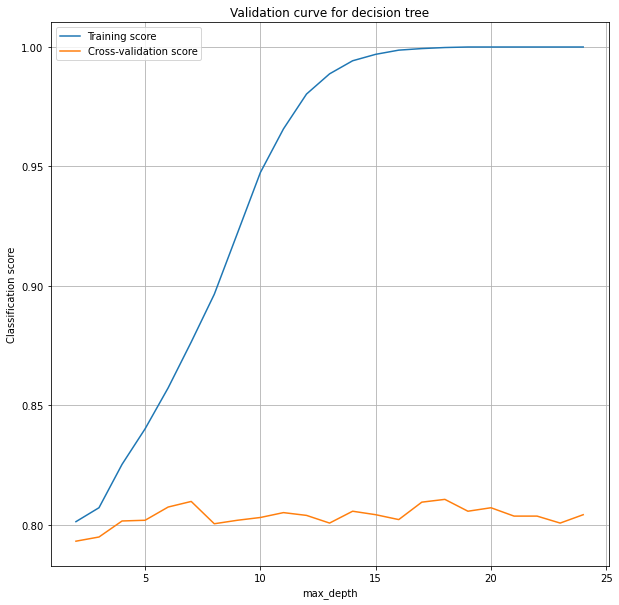

In [76]:

min_samples_leaf_range = np.arange(1, 21, 1)
print(min_samples_leaf_range)
print(vars(DecisionTreeClassifier()))


min_samples_leaf_range = np.arange(1, 160, 10)
generate_validation_curve(pipe, X_train, y_train, param_name="cfr__min_samples_leaf", param_range=np.arange(1, 160, 10), cv=5)


plt.figure()
#plt.xticks(min_samples_leaf_range)
plt.plot(min_samples_leaf_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(min_samples_leaf_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for decision tree')
plt.xlabel('min_samples_leaf')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()

plt.savefig(r'..\plot\{}_val_curve_min_samples_leaf.png'.format(data), figsize=(20, 20))
plt.show()

min_samples_split_range = np.arange(1, 300, 10) 
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__min_samples_split", param_range=min_samples_split_range, cv=5)

plt.figure()
#plt.xticks(min_samples_split_range)
plt.plot(min_samples_split_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(min_samples_split_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for decision tree')
plt.xlabel('min_samples_split')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.savefig(r'..\plot\{}_val_curve_min_samples_split.png'.format(data), figsize=(20, 20))

plt.show()

ccp_alpha_range = np.linspace(0, 0.1, 10)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__ccp_alpha", param_range=ccp_alpha_range, cv=5)

plt.figure()
#plt.xticks(ccp_alpha_range)
plt.plot(ccp_alpha_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(ccp_alpha_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for decision tree')
plt.xlabel('ccp_alpha')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.savefig(r'..\plot\{}_val_curve_ccp_alpha.png'.format(data), figsize=(20, 20))
plt.show()

max_depth_range = np.arange(2,25,1)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__max_depth", param_range=max_depth_range, cv=5)
plt.figure()
#plt.xticks(max_depth_range)
plt.plot(max_depth_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(max_depth_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for decision tree')
plt.xlabel('max_depth')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.savefig(r'..\plot\{}_val_curve_max_depth.png'.format(data), figsize=(20, 20))
plt.show()



In [77]:
param_grid = {'cfr__min_samples_split': min_samples_split_range, 
              "cfr__min_samples_leaf": min_samples_leaf_range,
              "cfr__ccp_alpha": ccp_alpha_range,
              "cfr__max_depth": max_depth_range
              }
cv = StratifiedKFold(n_splits=5, random_state=42)
dt_cv = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1)
dt_cv.fit(X_train, y_train)
print("Tuned dt best params: {}".format(dt_cv.best_params_))

ypred = dt_cv.predict(X_train)
print(classification_report(y_train, ypred))
print('######################')
ypred2 = dt_cv.predict(X_test)
print(classification_report(y_test, ypred2))

Tuned dt best params: {'cfr__ccp_alpha': 0.0, 'cfr__max_depth': 6, 'cfr__min_samples_leaf': 11, 'cfr__min_samples_split': 41}
              precision    recall  f1-score   support

       False       0.87      0.95      0.91      2697
        True       0.71      0.47      0.56       731

    accuracy                           0.85      3428
   macro avg       0.79      0.71      0.73      3428
weighted avg       0.83      0.85      0.83      3428

######################
              precision    recall  f1-score   support

       False       0.83      0.93      0.88      1141
        True       0.58      0.36      0.44       329

    accuracy                           0.80      1470
   macro avg       0.71      0.64      0.66      1470
weighted avg       0.78      0.80      0.78      1470



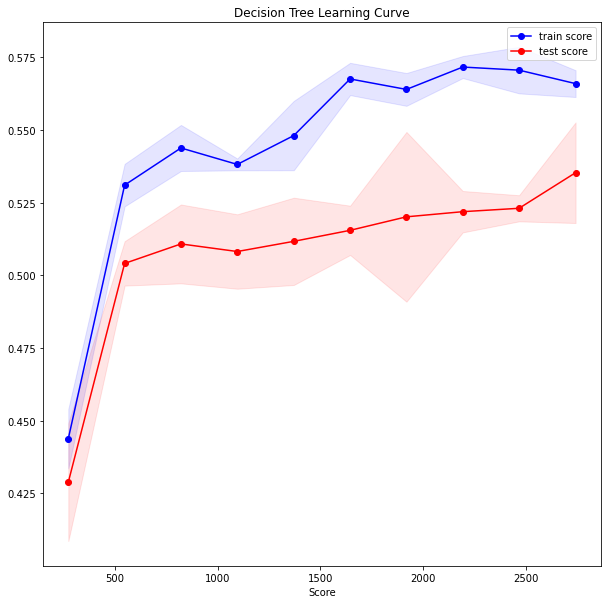

In [29]:
train_sizes, train_scores, test_scores = learning_curve(estimator=dt_cv.best_estimator_, X=X_train, y=y_train, 
        train_sizes=np.arange(0.1, 1.1, 0.1), n_jobs=-1, cv=StratifiedKFold(n_splits=5, random_state=42))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='train score', color='b', marker='o')
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, test_mean, label='test score', color='red', marker='o')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='red', alpha=0.1)
plt.title('Decision Tree Learning Curve')
plt.xlabel('Score')
#plt.grid(ls='--')
plt.legend(loc='best')
plt.show()

# SVM

In [ ]:
pipe = Pipeline([('std', StandardScaler()), ('cfr', SVC())])

print(vars(SVC()))

pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))
print(accuracy_score(y_test, pipe.predict(X_test)))

C_range = np.logspace(-2, 3, 6)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__C", param_range=C_range, cv=5, n_jobs=-1)

plt.figure()
plt.semilogx(C_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(C_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for SVM (linear kernel)')
plt.xlabel('C')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

gamma_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__gamma", param_range=gamma_range, cv=5, n_jobs=-1)

plt.figure()
plt.semilogx(gamma_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(gamma_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for SVM (linear kernel)')
plt.xlabel(r'$\gamma$')
plt.ylabel("Classification score")
plt.legend(loc="best"
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

kernel_options = ['linear', 'poly', 'rbf', 'sigmoid']
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__kernel", param_range=kernel_options, cv=5, n_jobs=-1)

plt.figure()
plt.plot(kernels_options, np.mean(train_scores, axis=1), label='Training score')
plt.plot(kernels_options, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for SVM')
plt.xlabel(r'kernels')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()



In [78]:
param_grid = {'cfr__C': C_range,
              'cfr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'cfr__gamma': gamma_range
              }
cv = StratifiedKFold(n_splits=5, random_state=42)
svc_cv = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1)
svc_cv.fit(X_train, y_train)
print("Tuned SVC best params: {}".format(svc_cv.best_params_))

ypred = svc_cv.predict(X_train)
print(classification_report(y_train, ypred))
print('######################')
ypred2 = dt_cv.predict(X_test)
print(classification_report(y_test, ypred2))

ValueError: Invalid parameter C for estimator DecisionTreeClassifier(). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(estimator=svc_cv.best_estimator_, X=X_train, y=y_train, 
        train_sizes=np.arange(0.1, 1.1, 0.1), n_jobs=-1, cv=StratifiedKFold(n_splits=5, random_state=42))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='train score', color='b', marker='o')
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, test_mean, label='test score', color='red', marker='o')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='red', alpha=0.1)
plt.title('Support Vector Machine Learning Curve')
plt.xlabel('Score')
plt.grid(ls='--')
plt.legend(loc='best')
plt.show()

# kNN

{'n_neighbors': 5, 'radius': None, 'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'p': 2, 'n_jobs': None, 'weights': 'uniform'}
0.8771878646441074
0.8367346938775511
0.8367346938775511


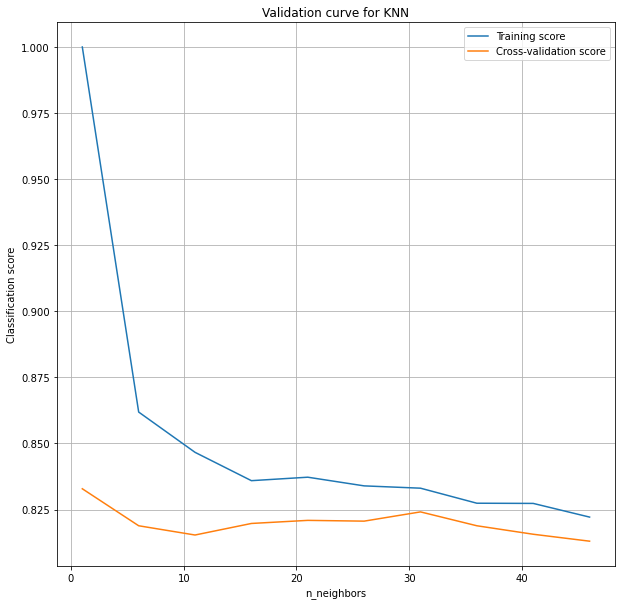

In [20]:
pipe = Pipeline([('std', StandardScaler()), ('cfr', KNeighborsClassifier())])

print(vars(KNeighborsClassifier()))

pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))
print(accuracy_score(y_test, pipe.predict(X_test)))

n_neighbors_range = np.arange(1, 50, 5)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__n_neighbors", param_range=n_neighbors_range, cv=5, n_jobs=-1)

plt.figure()
plt.plot(n_neighbors_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(n_neighbors_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for KNN')
plt.xlabel('n_neighbors')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

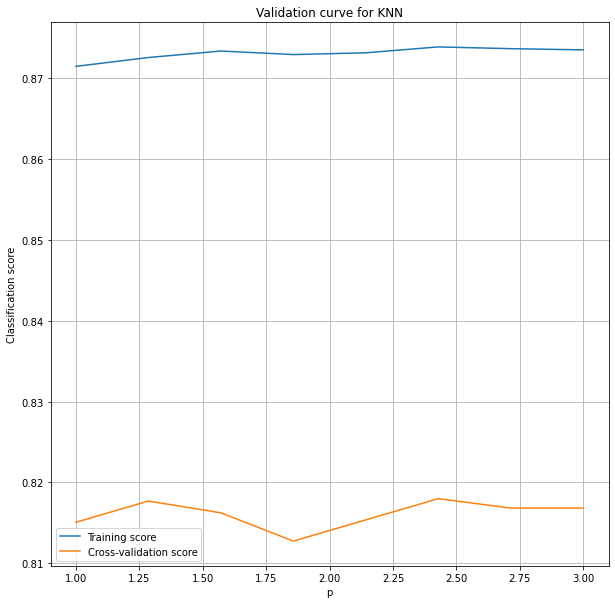

In [21]:
p_range = np.linspace(1, 3, 8)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__p", param_range=p_range, cv=5, n_jobs=-1)

plt.figure()
plt.plot(p_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(p_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for KNN')
plt.xlabel('p')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

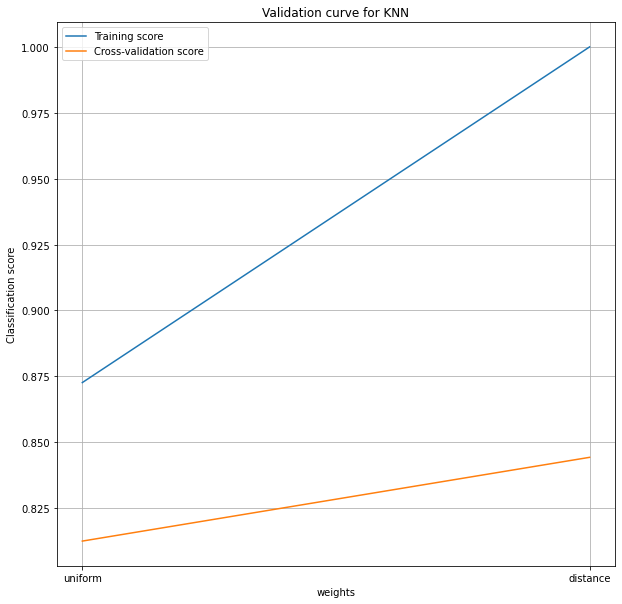

In [22]:
weights = ['uniform', 'distance']
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__weights", param_range=weights, cv=5, n_jobs=-1)

plt.figure()
plt.plot(weights, np.mean(train_scores, axis=1), label='Training score')
plt.plot(weights, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for KNN')
plt.xlabel('weights')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

In [23]:
param_grid = {'cfr__n_neighbors': n_neighbors_range,
              'cfr__weights': weights,
              'cfr__p': p_range
              }

cv = StratifiedKFold(n_splits=5, random_state=42)
knn_cv = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1)
knn_cv.fit(X_train, y_train)
print("Tuned KNN best params: {}".format(knn_cv.best_params_))

ypred = knn_cv.predict(X_train)
print(classification_report(y_train, ypred))
print('######################')
ypred2 = knn_cv.predict(X_test)
print(classification_report(y_test, ypred2))

Tuned KNN best params: {'cfr__n_neighbors': 36, 'cfr__p': 2.4285714285714284, 'cfr__weights': 'distance'}
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2697
        True       1.00      1.00      1.00       731

    accuracy                           1.00      3428
   macro avg       1.00      1.00      1.00      3428
weighted avg       1.00      1.00      1.00      3428

######################
              precision    recall  f1-score   support

       False       0.89      0.97      0.92      1141
        True       0.83      0.57      0.68       329

    accuracy                           0.88      1470
   macro avg       0.86      0.77      0.80      1470
weighted avg       0.87      0.88      0.87      1470



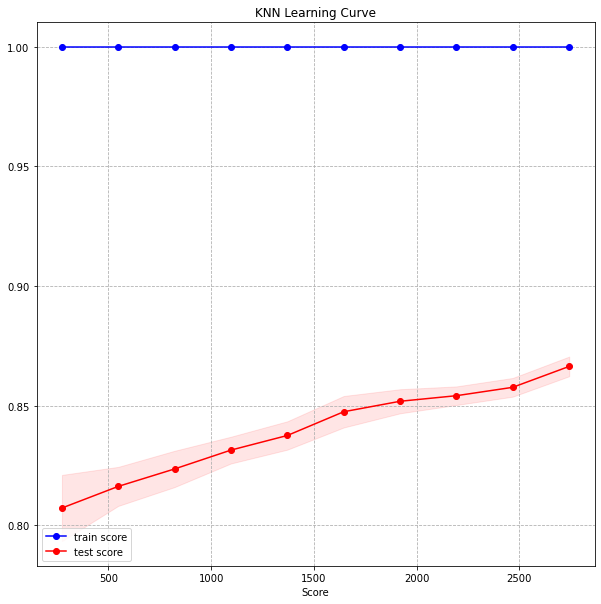

In [57]:
train_sizes, train_scores, test_scores = learning_curve(estimator=knn_cv.best_estimator_, X=X_train, y=y_train, 
        train_sizes=np.arange(0.1, 1.1, 0.1), n_jobs=-1, cv=StratifiedKFold(n_splits=5, random_state=42))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='train score', color='b', marker='o')
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, test_mean, label='test score', color='red', marker='o')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='red', alpha=0.1)
plt.title('KNN Learning Curve')
plt.xlabel('Score')
plt.grid(ls='--')
plt.legend(loc='best')
plt.show()

# ANN

{'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'batch_size': 'auto', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'power_t': 0.5, 'max_iter': 200, 'loss': 'log_loss', 'hidden_layer_sizes': (100,), 'shuffle': True, 'random_state': None, 'tol': 0.0001, 'verbose': False, 'warm_start': False, 'momentum': 0.9, 'nesterovs_momentum': True, 'early_stopping': False, 'validation_fraction': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-08, 'n_iter_no_change': 10, 'max_fun': 15000}
0.8573512252042007
0.8224489795918367
0.8224489795918367


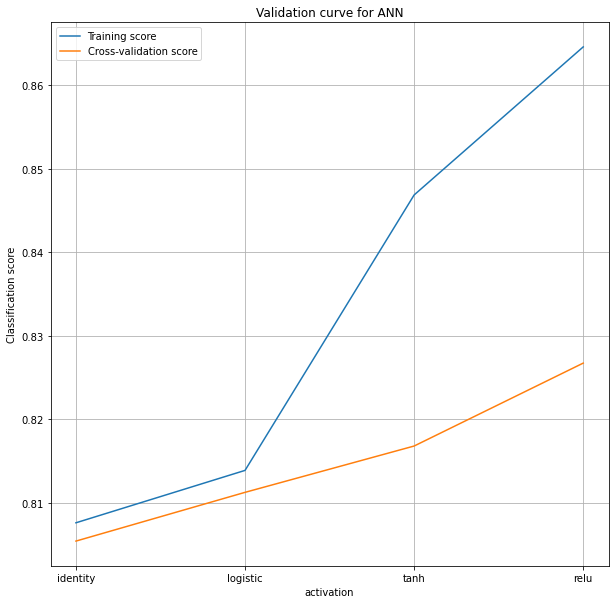

In [61]:
pipe = Pipeline([('std', StandardScaler()), ('cfr', MLPClassifier())])

print(vars(MLPClassifier()))

pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))
print(accuracy_score(y_test, pipe.predict(X_test)))

activation = ['identity', 'logistic', 'tanh', 'relu']
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__activation", param_range=activation, cv=5, n_jobs=-1)

plt.figure()
plt.plot(activation, np.mean(train_scores, axis=1), label='Training score')
plt.plot(activation, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for ANN')
plt.xlabel('activation')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

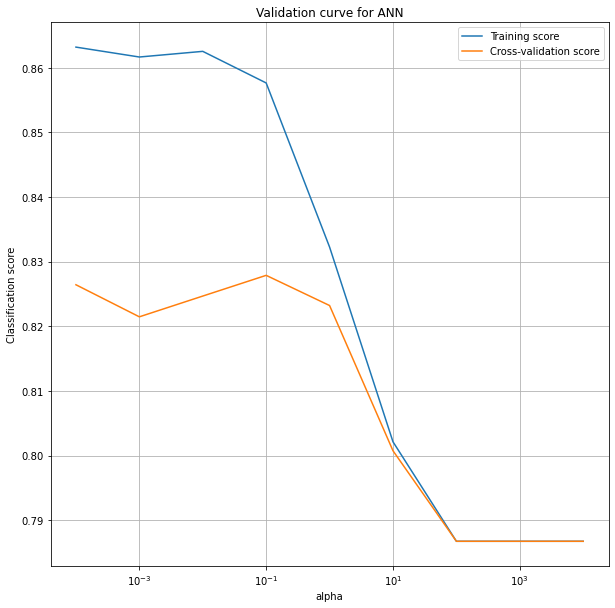

In [64]:
alpha = np.logspace(-4, 4, 9)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, param_name="cfr__alpha", param_range=alpha, cv=5, n_jobs=-1)

plt.figure()
plt.semilogx(alpha, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(alpha, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for ANN')
plt.xlabel('alpha')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [65]:
param_grid = {'cfr__alpha': alpha,
              }

cv = StratifiedKFold(n_splits=5, random_state=42)
ann_cv = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1)
ann_cv.fit(X_train, y_train)
print("Tuned ANN best params: {}".format(ann_cv.best_params_))

ypred = ann_cv.predict(X_train)
print(classification_report(y_train, ypred))
print('######################')
ypred2 = ann_cv.predict(X_test)
print(classification_report(y_test, ypred2))

Tuned ANN best params: {'cfr__n_neighbors': 36, 'cfr__p': 2.4285714285714284, 'cfr__weights': 'distance'}
              precision    recall  f1-score   support

       False       0.88      0.95      0.91      2697
        True       0.74      0.53      0.62       731

    accuracy                           0.86      3428
   macro avg       0.81      0.74      0.77      3428
weighted avg       0.85      0.86      0.85      3428

######################
              precision    recall  f1-score   support

       False       0.85      0.94      0.89      1141
        True       0.67      0.42      0.52       329

    accuracy                           0.83      1470
   macro avg       0.76      0.68      0.71      1470
weighted avg       0.81      0.83      0.81      1470



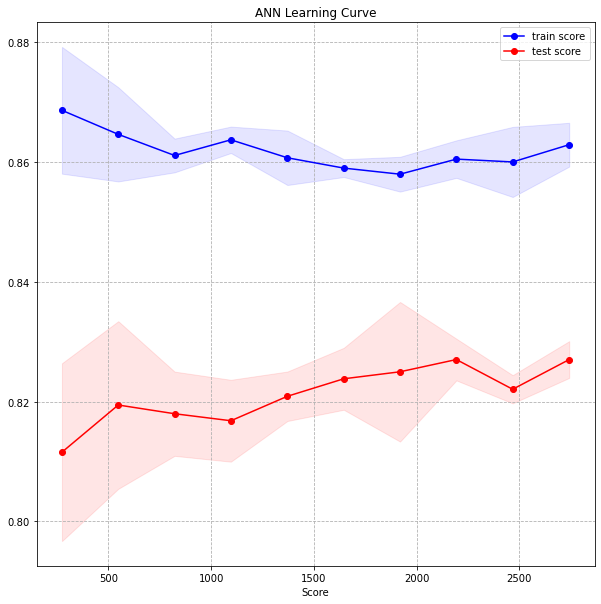

In [66]:
train_sizes, train_scores, test_scores = learning_curve(estimator=ann_cv.best_estimator_, X=X_train, y=y_train, 
        train_sizes=np.arange(0.1, 1.1, 0.1), n_jobs=-1, cv=StratifiedKFold(n_splits=5, random_state=42))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='train score', color='b', marker='o')
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, test_mean, label='test score', color='red', marker='o')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='red', alpha=0.1)
plt.title('ANN Learning Curve')
plt.xlabel('Score')
plt.grid(ls='--')
plt.legend(loc='best')
plt.show()

# Boosting/ AdaBoost

In [7]:
print(vars(AdaBoostClassifier()))
#base = dt_cv.best_estimator_.get_params()['cfr']
base = DecisionTreeClassifier(ccp_alpha=0.1, max_depth=6, min_samples_leaf=11, min_samples_split=41)
pipe = Pipeline([('std', StandardScaler()), 
                 ('cfr', AdaBoostClassifier(base_estimator=base))])

print(pipe)
print('===\n')



pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))
print(accuracy_score(y_test, pipe.predict(X_test)))

{'base_estimator': None, 'n_estimators': 50, 'estimator_params': (), 'learning_rate': 1.0, 'random_state': None, 'algorithm': 'SAMME.R'}
Pipeline(steps=[('std', StandardScaler()),
                ('cfr',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.1,
                                                                          max_depth=6,
                                                                          min_samples_leaf=11,
                                                                          min_samples_split=41)))])
===

0.7867561260210035
0.7761904761904762
0.7761904761904762


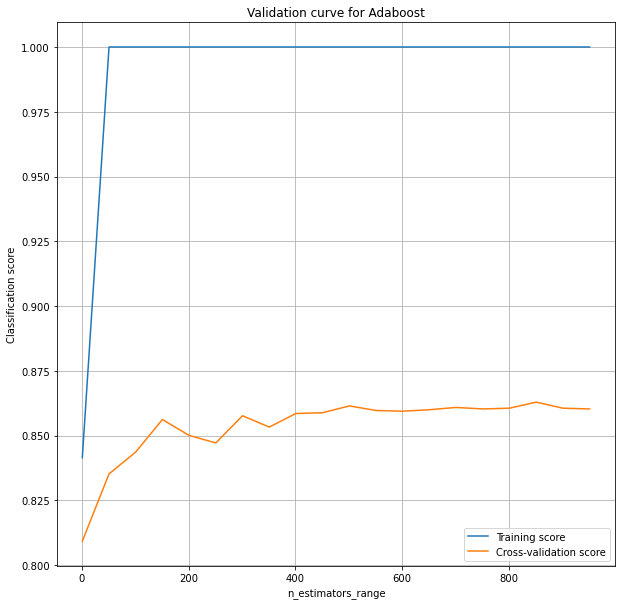

In [94]:
n_estimators_range = np.arange(1,1000,50)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, 
                                    param_name="cfr__n_estimators", param_range=n_estimators_range, cv=5, n_jobs=-1)

plt.figure()
plt.plot(n_estimators_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(n_estimators_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for Adaboost')
plt.xlabel('n_estimators_range')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

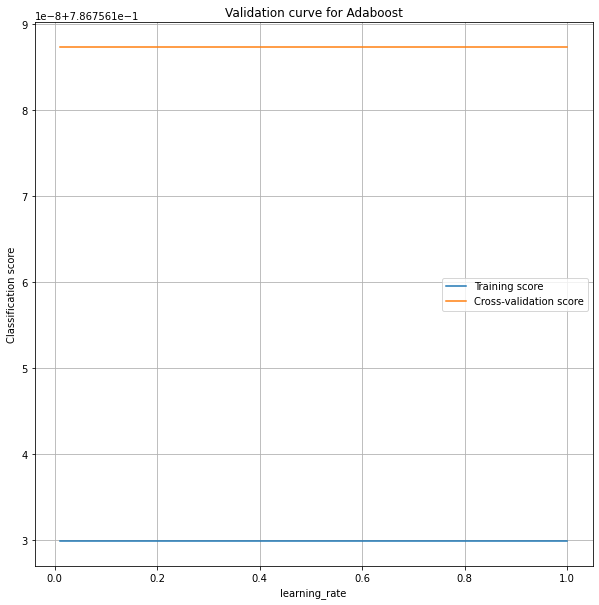

In [13]:
learning_rate_range = np.linspace(0.01, 1, 20)
train_scores, test_scores = validation_curve(pipe, X_train, y_train, 
                                    param_name="cfr__learning_rate", param_range=learning_rate_range, cv=5, n_jobs=-1)

plt.figure()
plt.plot(learning_rate_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(learning_rate_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for Adaboost')
plt.xlabel('learning_rate')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [14]:
param_grid = {'cfr__learning_rate': np.linspace(0.01, 1, 10),
              'cfr__n_estimators':np.arange(1, 500,50)
              }

cv = StratifiedKFold(n_splits=5, random_state=42)
boost_cv = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1)
boost_cv.fit(X_train, y_train)
print("Tuned Boosted Decision Tree best params: {}".format(boost_cv.best_params_))

ypred = boost_cv.predict(X_train)
print(classification_report(y_train, ypred))
print('######################')
ypred2 = boost_cv.predict(X_test)
print(classification_report(y_test, ypred2))

KeyboardInterrupt: 

"\ntrain_sizes, train_scores, test_scores = learning_curve(estimator=boost_cv.best_estimator_, X=X_train, y=y_train, \n        train_sizes=np.arange(0.1, 1.1, 0.1), n_jobs=-1, cv=StratifiedKFold(n_splits=5, random_state=42))\n\ntrain_mean = np.mean(train_scores, axis=1)\ntest_mean = np.mean(test_scores, axis=1)\n\ntrain_std = np.std(train_scores, axis=1)\ntest_std = np.std(test_scores, axis=1)\n\nplt.plot(train_sizes, train_mean, label='train score', color='b', marker='o')\nplt.fill_between(train_sizes, train_mean + train_std,\n                 train_mean - train_std, color='blue', alpha=0.1)\nplt.plot(train_sizes, test_mean, label='test score', color='red', marker='o')\n\nplt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='red', alpha=0.1)\nplt.title('Boosted Decision Tree Learning Curve')\nplt.xlabel('Score')\nplt.grid(ls='--')\nplt.legend(loc='best')\nplt.show()\n"

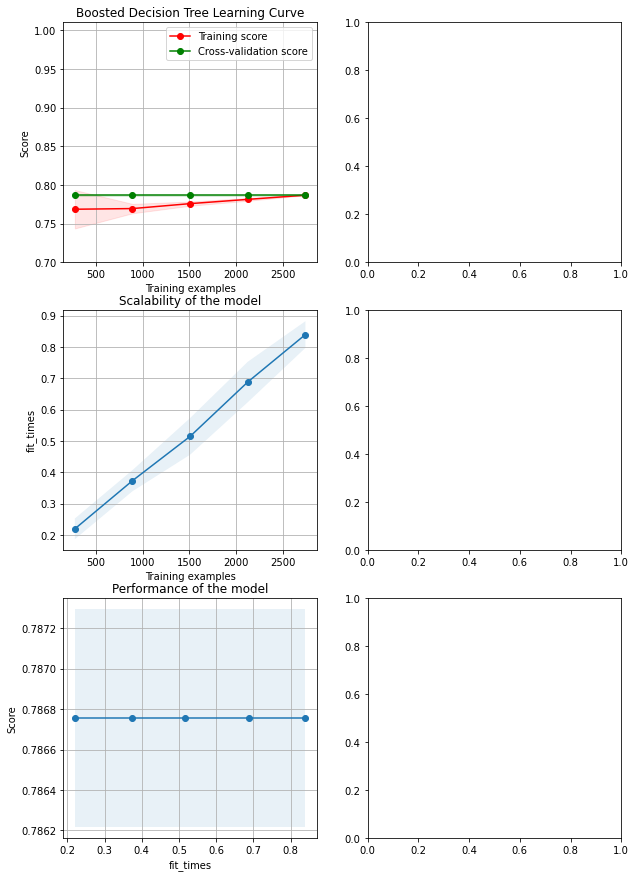

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))


plot_learning_curve(dt_cv.best_estimator_
                    , 'Boosted Decision Tree Learning Curve', 
                    X_train, y_train, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=StratifiedKFold(n_splits=5, random_state=42), n_jobs=-1)


'''
train_sizes, train_scores, test_scores = learning_curve(estimator=boost_cv.best_estimator_, X=X_train, y=y_train, 
        train_sizes=np.arange(0.1, 1.1, 0.1), n_jobs=-1, cv=StratifiedKFold(n_splits=5, random_state=42))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='train score', color='b', marker='o')
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, test_mean, label='test score', color='red', marker='o')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='red', alpha=0.1)
plt.title('Boosted Decision Tree Learning Curve')
plt.xlabel('Score')
plt.grid(ls='--')
plt.legend(loc='best')
plt.show()
'''

<function matplotlib.pyplot.show>

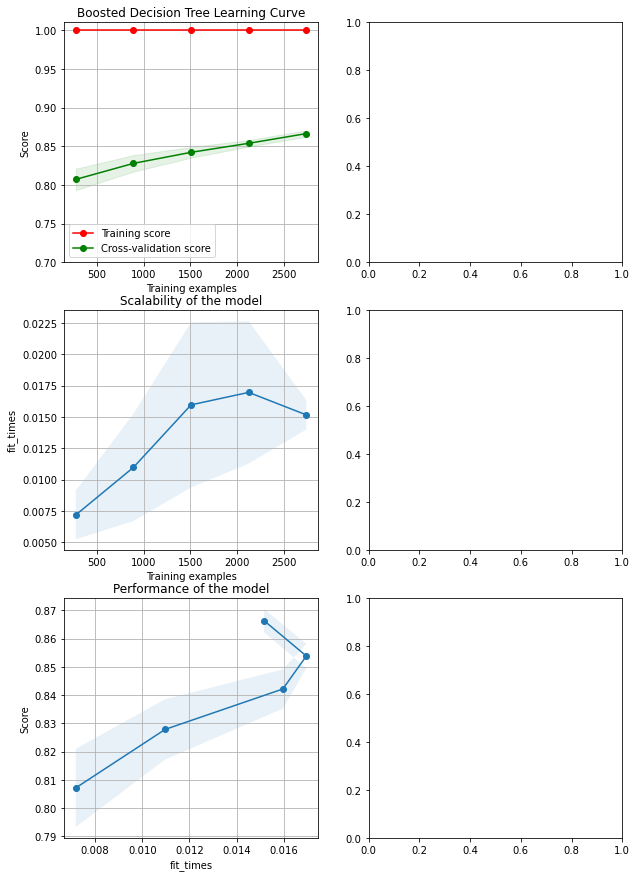

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

plot_learning_curve(knn_cv.best_estimator_
                    , 'Boosted Decision Tree Learning Curve', 
                    X_train, y_train, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=StratifiedKFold(n_splits=5, random_state=42), n_jobs=-1)
plt.show

In [32]:
plt.savefig(r'..\plot\fig.png')

<Figure size 720x720 with 0 Axes>

In [87]:
import warnings

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import datetime
import pickle
import os









def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    '''
    Code taken from (Reference): Scikit-Learn example 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    '''
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt



def vanilla_fit(X_train, y_train, pipe):
    pipe.fit(X_train, y_train)
    train_score = pipe.score(X_train, y_train)
    print(train_score)
    #print(accuracy_score(y_test, pipe.predict(X_test)))
    return train_score


def generate_validation_curve(pipe, X_train, y_train, model, param_name, search_range,   data='wine'):
    train_scores, test_scores = validation_curve(estimator=pipe, X=X_train, y=y_train, 
                                                 param_name="cfr__"+param_name,
                                                 param_range=search_range, cv=5,
                                                 n_jobs=-1)
    plt.figure(figsize=(5,5))
    plt.plot(search_range, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(search_range, np.mean(test_scores, axis=1), label='Cross-validation score')
    plt.title('Validation curve for{}'.format(model))
    plt.xlabel(param_name)
    plt.ylabel("Classification score")
    plt.legend(loc="best")
    plt.grid()

    plt.savefig(r'..\plot\{}_val_curve_{}_{}.png'.format(data, model, param_name), figsize=(5, 5))
    plt.show()
    
def tune_hyperparameter(param_grid, pipe, X_train, y_train):
    cv = StratifiedKFold(n_splits=5, random_state=42)
    tuned_model = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1)
    tuned_model.fit(X_train, y_train)
    print("Tuned params: {}".format(tuned_model.best_params_))
    
    ypred = tuned_model.predict(X_train)
    print(classification_report(y_train, ypred))
    return tuned_model

def decision_tree_experiments(X_train, y_train, data='wine'):
    pipe = Pipeline([('std', StandardScaler()), ('cfr', DecisionTreeClassifier())])
    vanilla_fit(X_train, y_train, pipe)
    
    
    min_samples_split_range = np.arange(2, 300, 150)
    min_samples_leaf_range = np.arange(2, 160, 80)
    ccp_alpha_range = np.linspace(0, 0.1, 2)
    max_depth_range = np.arange(2, 10, 5)
    
    generate_validation_curve(pipe, X_train, y_train, model='Decision Tree', 
                              param_name="min_samples_leaf", 
                              search_range=min_samples_leaf_range, data=data)
    generate_validation_curve(pipe, X_train, y_train, model='Decision Tree', 
                              param_name="min_samples_split", 
                              search_range=min_samples_split_range , data=data)    
    generate_validation_curve(pipe, X_train, y_train, model='Decision Tree', 
                          param_name="ccp_alpha", 
                          search_range=ccp_alpha_range , data=data)    
    generate_validation_curve(pipe, X_train, y_train, model='Decision Tree', 
                          param_name="max_depth", 
                          search_range=max_depth_range , data=data)    
    
    tuned_model = tune_hyperparameter({'cfr__min_samples_split': min_samples_split_range, 
                                          "cfr__min_samples_leaf": min_samples_leaf_range,
                                          "cfr__ccp_alpha": ccp_alpha_range,
                                          "cfr__max_depth": max_depth_range
                                          }, 
                                       pipe, X_train, y_train)
    return tuned_model   

def knn_experiments(X_train, y_train, data='wine'):
    pipe =  Pipeline([('std', StandardScaler()), ('cfr', KNeighborsClassifier())])
    vanilla_fit(X_train, y_train, pipe)
    
    
    n_neighbors_range = np.arange(1, 50, 25)
    p_range = np.linspace(1, 3, 2)
    weights = ['uniform', 'distance']
    generate_validation_curve(pipe, X_train, y_train, model='kNN', 
                              param_name="n_neighbors", 
                              search_range=n_neighbors_range, data=data)
    generate_validation_curve(pipe, X_train, y_train, model='kNN', 
                              param_name="p", 
                              search_range=p_range , data=data)    
    generate_validation_curve(pipe, X_train, y_train, model='kNN', 
                          param_name="weights", 
                          search_range=weights , data=data)    

    tuned_model = tune_hyperparameter({'cfr__n_neighbors': n_neighbors_range,
                                      'cfr__weights': weights,
                                      'cfr__p': p_range
                                      }, 
                                       pipe, X_train, y_train)
    return tuned_model  


def neural_network_experiments(X_train, y_train, data='wine'):
    pipe =  Pipeline([('std', StandardScaler()), ('cfr', MLPClassifier())])
    vanilla_fit(X_train, y_train, pipe)
    
    
    activation = ['relu']
    alpha = np.logspace(-4, 4, 2)
    
    generate_validation_curve(pipe, X_train, y_train, model='Neural Network', 
                              param_name="activation", 
                              search_range=activation, data=data)
    generate_validation_curve(pipe, X_train, y_train, model='Neural Network', 
                              param_name="alpha", 
                              search_range=alpha, data=data)
    tuned_model = tune_hyperparameter({'cfr__alpha': alpha,
                                       }, 
                                       pipe, X_train, y_train)
    return tuned_model    

def support_vector_machine_experiments(X_train, y_train, data='wine'):
    pipe =  Pipeline([('std', StandardScaler()), ('cfr', SVC())])
    vanilla_fit(X_train, y_train, pipe)
    
    C_range = np.logspace(-2, 3, 1)
    gamma_range = np.logspace(-6, -1, 1)
    kernel_options = ['linear']
    
    generate_validation_curve(pipe, X_train, y_train, model='Support Vector Machine', 
                              param_name="C", 
                              search_range=C_range, data=data)
    generate_validation_curve(pipe, X_train, y_train, model='Support Vector Machine', 
                                  param_name="gamma", 
                                  search_range=gamma_range, data=data)    
    generate_validation_curve(pipe, X_train, y_train, model='Support Vector Machine', 
                                  param_name="kernel", 
                                  search_range=kernel_options, data=data)    
    
    
    tuned_model = tune_hyperparameter({'cfr__C': C_range,
                                      'cfr__kernel': kernel_options,
                                      'cfr__gamma': gamma_range}, 
                                       pipe, X_train, y_train)
    return tuned_model    



def boosted_tree_experiments(base, X_train, y_train, data='wine'):
    pipe =  Pipeline([('std', StandardScaler()), 
                 ('cfr', AdaBoostClassifier(base_estimator=base))])
    vanilla_fit(X_train, y_train, pipe)
    
    n_estimators_range = np.arange(1,3, 1)
    learning_rate_range = np.linspace(0.01, 1, 1)
    
    generate_validation_curve(pipe, X_train, y_train, model='Boosted Tree', 
                              param_name="n_estimators", 
                              search_range=n_estimators_range, data=data)
    generate_validation_curve(pipe, X_train, y_train, model='Boosted Tree', 
                              param_name="learning_rate", 
                              search_range=learning_rate_range, data=data)
    
    
    tuned_model = tune_hyperparameter({'cfr__learning_rate': learning_rate_range,
              'cfr__n_estimators': n_estimators_range
              }, 
                                       pipe, X_train, y_train)
    return tuned_model    



def get_dataset1(verbose=True):
    df = pd.read_csv(os.path.join(os.pardir, "data", "winequality-white.csv"), sep=';')
    y1 = df['quality'] >= 7
    X1 = df.drop(columns='quality')
    
    if verbose == True:
        print(df.shape)
        print(df.info())
        print(df.shape)
        print(df.info())
        print(df.describe())
        df.describe()
        plt.rcParams["figure.figsize"] = 20, 20
        # Basic correlogram
        sns.pairplot(df)
        plt.show()
        plt.savefig(r'..\plot\wine_scatterplot.png', figsize=(20, 20))
        
        print(X1.shape)
        print(y1.shape)
        print(X1.head())
        print(y1)

    return X1, y1

    return X1, y1

def get_dataset2():
    X2 = None
    y2 = None
    return X2, y2


def test_score(result_df, X_train, y_train, X_test, y_test):
    result_df['Training Time (sec)'] = ""
    result_df['Training Score'] = ""
    result_df['Testing Time (sec)'] = ""
    result_df['Testing Score'] = ""
    
    for index, row in result_df.iterrows():
        tuned_model = row['Tuned Model'].best_estimator_
        start = datetime.datetime.now()
        tuned_model.fit(X_train, y_train)
        end = datetime.datetime.now()
        training_time = (end - start).microseconds / (1000*1000)          #1
        result_df.at[index, 'Training Time (sec)'] = training_time
        training_score = tuned_model.score(X_train, y_train)
        print(training_score)
        result_df.at[index, 'Training Score'] = training_score        #2 
        
        start = datetime.datetime.now()
        test_score = tuned_model.score(X_test, y_test)
        #print(test_score)
        result_df.at[index, 'Testing Score'] = test_score            #3
        end = datetime.datetime.now()
        testing_time = (end - start).microseconds / (1000*1000)               #4
        result_df.at[index, 'Testing Time (sec)'] = testing_time
    
    print(result_df)
    
    #now make some plots
    result_df_wine.set_index('Model', inplace=True)
    result_df_wine[['Training Score', 'Testing Score']].plot(kind='bar')
    result_df_wine[['Training Time (sec)', 'Testing Time (sec)']].plot(kind='bar')
    return result_df

def main(verbose=True, warm_start=False):
    
    X1, y1 = get_dataset1(verbose)
    #X2, y2 = get_dataset2()



    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42)
    #X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

    
    if not warm_start:
        '''
        decision_tree:
            vanilla fit
            validation curves
            gridsearch
            learning curves
        '''
        tuned_decision_tree_model_wine = decision_tree_experiments(X_train1, y_train1, data='wine')
        #tuned_decision_tree_model_dataset2 = decision_tree_experiments(X_train1, y_train1, data='dataset2')
        #generate_learning_curves(tuned_decision_tree_model_wine, 
        #                         tuned_decision_tree_model_dataset2,
        #                         X_train1, y_train1, X_train2, y_train2)
        pickle.dump(tuned_decision_tree_model_wine, open(os.path.join(os.pardir, "models", "tuned_decision_tree_model_wine.pkl"), 'wb'))
        #pickle.dump(tuned_decision_tree_model_dataset2, open(os.path.join(os.pardir, "models", "tuned_decision_tree_model_dataset2.pkl"), 'wb'))


        tuned_boosted_tree_model_wine = boosted_tree_experiments(tuned_decision_tree_model_wine.best_estimator_.get_params()['cfr'],
                                                                 X_train1, y_train1, data='wine')
        #tuned_boosted_tree_model_dataset2 = boosted_tree_experiments(tuned_decision_tree_model_dataset2.best_estimator_.get_params()['cfr'], X_train1, y_train1, data='dataset2')
        #generate_learning_curves(tuned_boosted_tree_model_wine, 
        #                         tuned_boosted_tree_model_dataset2,
        #                         X_train1, y_train1, X_train2, y_train2)
        pickle.dump(tuned_boosted_tree_model_wine, open(os.path.join(os.pardir, "models", "tuned_boosted_tree_model_wine.pkl"), 'wb'))
        #pickle.dump(tuned_boosted_tree_model_dataset2, open(os.path.join(os.pardir, "models", "tuned_boosted_tree_model_dataset2.pkl"), 'wb'))


        tuned_knn_model_wine = knn_experiments(X_train1, y_train1, data='wine')
        #tuned_knn_model_dataset2 = knn_experiments(X_train1, y_train1, data='dataset2')
        #generate_learning_curves(tuned_knn_model_wine, 
        #                         tuned_knn_model_dataset2,
        #                         X_train1, y_train1, X_train2, y_train2)
        pickle.dump(tuned_knn_model_wine, open(os.path.join(os.pardir, "models", "tuned_knn_model_wine.pkl"), 'wb'))
        #pickle.dump(tuned_knn_model_dataset2, open(os.path.join(os.pardir, "models", "tuned_knn_model_dataset2.pkl"), 'wb'))


        tuned_neural_network_model_wine = neural_network_experiments(X_train1, y_train1, data='wine')
        #tuned_neural_network_model_dataset2 = neural_network_experiments(X_train1, y_train1, data='dataset2')
        #generate_learning_curves(tuned_neural_network_model_wine, 
        #                         tuned_neural_network_model_dataset2,
        #                         X_train1, y_train1, X_train2, y_train2)
        pickle.dump(tuned_neural_network_model_wine, open(os.path.join(os.pardir, "models", "tuned_neural_network_model_wine.pkl"), 'wb'))
        #pickle.dump(tuned_neural_network_model_dataset2, open(os.path.join(os.pardir, "models", "tuned_neural_network_model_dataset2.pkl"), 'wb'))

        tuned_support_vector_machine_model_wine = support_vector_machine_experiments(X_train1, y_train1, data='wine')
        #tuned_support_vector_machine_model_dataset2 = support_vector_machine_experiments(X_train1, y_train1, data='dataset2')
        #generate_learning_curves(tuned_support_vector_machine_model_wine, 
        #                         tuned_support_vector_machine_model_dataset2,
        #                         X_train1, y_train1, X_train2, y_train2)
        pickle.dump(tuned_support_vector_machine_model_wine, open(os.path.join(os.pardir, "models", "tuned_support_vector_machine_model_wine.pkl"), 'wb'))
        #pickle.dump(tuned_support_vector_machine_model_dataset2, open(os.path.join(os.pardir, "models", "tuned_support_vector_machine_model_dataset2.pkl"), 'wb'))

    if warm_start:
        tuned_decision_tree_model_wine = pickle.load(open(os.path.join(os.pardir, "models", "tuned_decision_tree_model_wine.pkl"), 'rb'))
        #tuned_decision_tree_model_dataset2 = pickle.load(open(os.path.join(os.pardir, "models", "tuned_decision_tree_model_dataset2.pkl"), 'rb'))
        
        tuned_boosted_tree_model_wine = pickle.load(open(os.path.join(os.pardir, "models", "tuned_boosted_tree_model_wine.pkl"), 'rb'))
        #tuned_boosted_tree_model_dataset2 = pickle.load(open(os.path.join(os.pardir, "models", "tuned_boosted_tree_model_dataset2.pkl"), 'rb'))
        
        tuned_knn_model_wine = pickle.load(open(os.path.join(os.pardir, "models", "tuned_knn_model_wine.pkl"), 'rb'))
        #tuned_knn_model_dataset2 = pickle.load(open(os.path.join(os.pardir, "models", "tuned_knn_model_dataset2.pkl"), 'rb'))
        
        tuned_neural_network_model_wine = pickle.load(open(os.path.join(os.pardir, "models", "tuned_neural_network_model_wine.pkl"), 'rb'))
        #tuned_neural_network_model_dataset2 = pickle.load(open(os.path.join(os.pardir, "models", "tuned_neural_network_model_dataset2.pkl"), 'rb'))
        
        tuned_support_vector_machine_model_wine = pickle.load(open(os.path.join(os.pardir, "models", "tuned_support_vector_machine_model_wine.pkl"), 'rb'))
        #tuned_support_vector_machine_model_dataset2 = pickle.load(open(os.path.join(os.pardir, "models", "tuned_support_vector_machine_model_dataset2.pkl"), 'rb'))
      
    result_data_wine = [['Decision Tree', 'wine', tuned_decision_tree_model_wine],
                   ['Boosted Tree', 'wine', tuned_boosted_tree_model_wine],
                   ['kNN', 'wine', tuned_knn_model_wine],
                   ['Neural Network', 'wine', tuned_neural_network_model_wine],
                   ['SVM', 'wine', tuned_support_vector_machine_model_wine]
                   ]

    #===============================================================================================
    # result_data_2 = [['Decision Tree', 'dataset2', tuned_decision_tree_model_dataset2],
    #                ['Boosted Tree', 'dataset2', tuned_boosted_tree_model_dataset2],
    #                ['kNN', 'dataset2', tuned_knn_model_dataset2],
    #                ['Neural Network', 'dataset2', tuned_neural_network_model_dataset2],
    #                ['SVM', 'dataset2', tuned_support_vector_machine_model_dataset2]]
    #===============================================================================================
                            
    result_df_wine = pd.DataFrame(result_data_wine, columns=['Model', 'Dataset', 'Tuned Model'])
    #result_df_2 = pd.DataFrame(result_data_2, columns=['Model', 'Dataset', 'Tuned Model'])
    test_score(result_df_wine, X_train1, y_train1, X_test1, y_test1)
    #test_score(result_df_2, X_train2, y_train2, X_test2, y_test2)
    return result_df_wine#, result_df_2
    
    
def generate_learning_curves(tuned_model_1, tuned_model_2, X_train1, y_train1, X_train2, y_train2):
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    plot_learning_curve(tuned_model_1.best_estimator_
                        , 'Wine Data', 
                        X_train1, y_train1, axes=axes[:, 0], ylim=(0.7, 1.01),
                        cv=StratifiedKFold(n_splits=5, random_state=42), n_jobs=-1)
    #plot_learning_curve(tuned_model_2.best_estimator_
    #                    , 'Dataset2', 
    #                    X_train2, y_train2, axes=axes[:, 1], ylim=(0.7, 1.01),
    #                    cv=StratifiedKFold(n_splits=5, random_state=42), n_jobs=-1)
    plt.show()
    
    
    

    

1.0


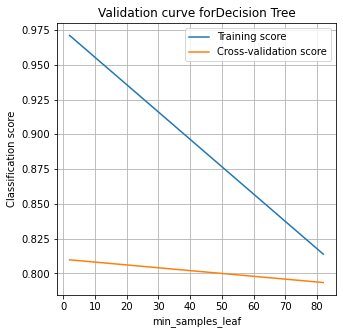

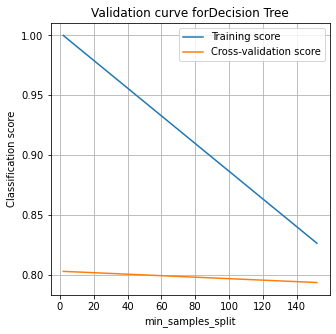

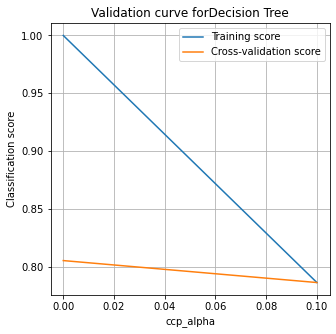

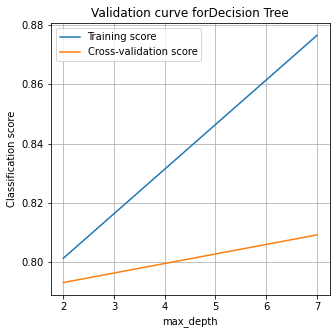

Tuned params: {'cfr__ccp_alpha': 0.0, 'cfr__max_depth': 7, 'cfr__min_samples_leaf': 2, 'cfr__min_samples_split': 2}
              precision    recall  f1-score   support

       False       0.90      0.94      0.92      2697
        True       0.74      0.60      0.66       731

    accuracy                           0.87      3428
   macro avg       0.82      0.77      0.79      3428
weighted avg       0.86      0.87      0.86      3428

1.0


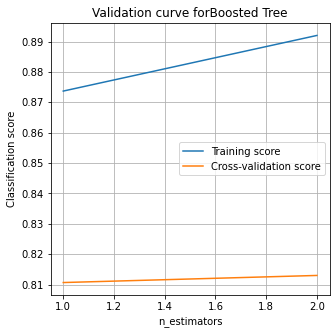

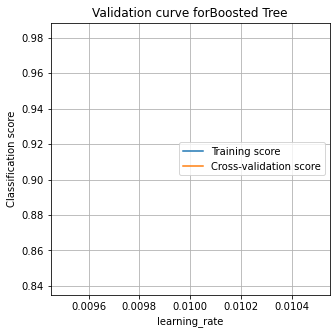

Tuned params: {'cfr__learning_rate': 0.01, 'cfr__n_estimators': 2}
              precision    recall  f1-score   support

       False       0.90      0.96      0.93      2697
        True       0.80      0.61      0.69       731

    accuracy                           0.89      3428
   macro avg       0.85      0.79      0.81      3428
weighted avg       0.88      0.89      0.88      3428

0.8771878646441074


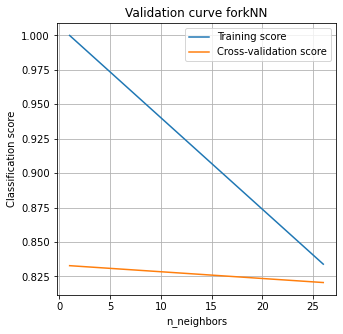

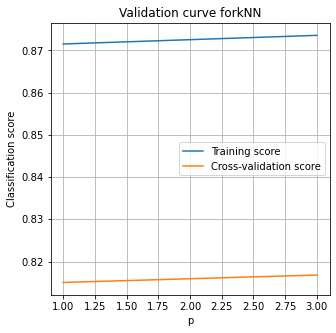

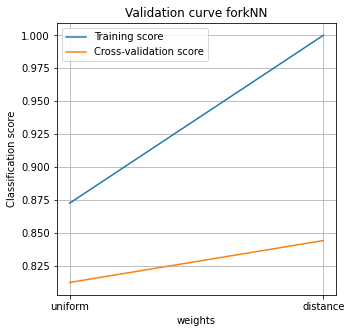

Tuned params: {'cfr__n_neighbors': 26, 'cfr__p': 3.0, 'cfr__weights': 'distance'}
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2697
        True       1.00      1.00      1.00       731

    accuracy                           1.00      3428
   macro avg       1.00      1.00      1.00      3428
weighted avg       1.00      1.00      1.00      3428

0.8620186697782963


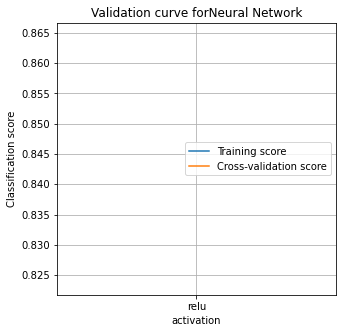

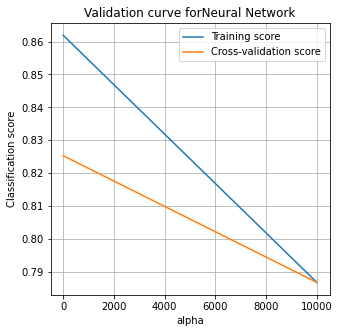

Tuned params: {'cfr__alpha': 0.0001}
              precision    recall  f1-score   support

       False       0.88      0.95      0.91      2697
        True       0.73      0.53      0.61       731

    accuracy                           0.86      3428
   macro avg       0.80      0.74      0.76      3428
weighted avg       0.85      0.86      0.85      3428

0.8433488914819136


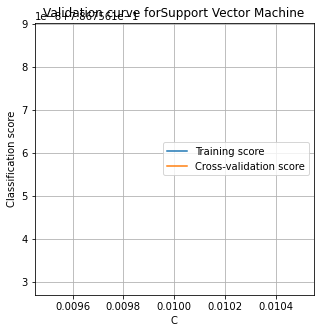

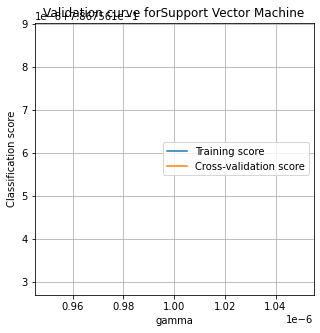

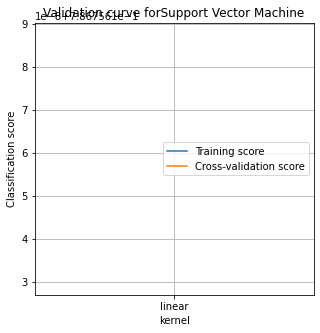

Tuned params: {'cfr__C': 0.01, 'cfr__gamma': 1e-06, 'cfr__kernel': 'linear'}
              precision    recall  f1-score   support

       False       0.79      1.00      0.88      2697
        True       0.00      0.00      0.00       731

    accuracy                           0.79      3428
   macro avg       0.39      0.50      0.44      3428
weighted avg       0.62      0.79      0.69      3428

            Model Dataset                                        Tuned Model  \
0   Decision Tree    wine  GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...   
1    Boosted Tree    wine  GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...   
2             kNN    wine  GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...   
3  Neural Network    wine  GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...   

   Training Time  Training Score  Testing Time  Testing Score  
0              0               0             0              0  
1              0               0             0              0  
2  

In [41]:
main(False)

In [88]:
result_df_wine = main(verbose=False, warm_start=True)

0.8696032672112018
0.8850641773628938
1.0
0.8567677946324388
0.7867561260210035
            Model Dataset                                        Tuned Model  \
0   Decision Tree    wine  GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...   
1    Boosted Tree    wine  GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...   
2             kNN    wine  GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...   
3  Neural Network    wine  GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...   
4             SVM    wine  GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...   

  Training Time (sec) Training Score Testing Time (sec) Testing Score  
0            0.021939       0.869603           0.001996      0.814286  
1            0.031914       0.885064            0.00399      0.817007  
2            0.009972              1           0.281581      0.879592  
3            0.236024       0.856768           0.005985      0.823129  
4            0.094747       0.786756           0.022938       0.77619  


KeyError: 'Model'

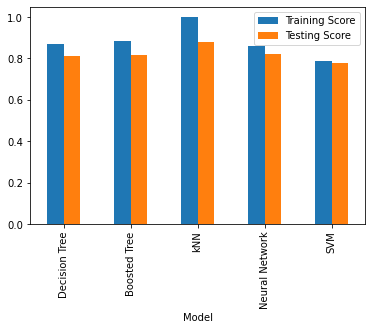

In [84]:
result_df_wine.set_index('Model', inplace=True)
result_df_wine[['Training Score', 'Testing Score']].plot(kind='bar')